In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
import sklearn
print(sklearn.__version__)

1.2.2


# Understand dataset

In [24]:
print("oke")
import torch
print(torch.__version__)
print(torch.cuda.is_available())

oke
2.4.0+cpu
False


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/kaggle/input/playground-series-s3e2/train.csv')
target_col = "stroke"

def format_form(df):
    if 'id' in df.columns:
        df = df.drop(columns=["id"])
    if 'gender' in df.columns:
        df = df.drop(df[df["gender"] == "Other"].index)
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)

    df.columns = df.columns.str.lower()
    for column in df.select_dtypes(include=['object']).columns:
        df[column] = df[column].str.lower()
    for column in df.select_dtypes(include=['number']).columns:
        if(df[column].nunique() == 2):
            df[column] = df[column].astype(bool)
            df[column] = df[column].replace({True: 'yes', False: 'no'})

    # Get a list of column names grouped by data type
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    # Reorder the columns in the DataFrame
    new_column_order = categorical_cols + numerical_cols
    new_column_order.remove(target_col)
    new_column_order.append(target_col)
    df = df[new_column_order]

    df = df.drop_duplicates()
    df = df.reset_index(drop=True)
    return df

df = format_form(df)
df.head(5).T

,0,1,2,3,4
gender,male,male,female,male,female
hypertension,no,no,no,no,no
heart_disease,no,no,no,no,no
ever_married,yes,yes,yes,yes,no
work_type,private,private,private,private,private
residence_type,urban,rural,rural,urban,rural
smoking_status,never smoked,formerly smoked,unknown,never smoked,never smoked
age,28.0,33.0,42.0,56.0,24.0
avg_glucose_level,79.53,78.44,103.0,64.87,73.36
bmi,31.1,23.9,40.3,28.8,28.8


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15303 entries, 0 to 15302
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             15303 non-null  object 
 1   hypertension       15303 non-null  object 
 2   heart_disease      15303 non-null  object 
 3   ever_married       15303 non-null  object 
 4   work_type          15303 non-null  object 
 5   residence_type     15303 non-null  object 
 6   smoking_status     15303 non-null  object 
 7   age                15303 non-null  float64
 8   avg_glucose_level  15303 non-null  float64
 9   bmi                15303 non-null  float64
 10  stroke             15303 non-null  object 
dtypes: float64(3), object(8)
memory usage: 1.3+ MB


In [27]:
categorical_columns = df.select_dtypes(include=['object']).columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

In [28]:
median_col = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'hypertension', 'heart_disease', 'age']
mean_col = ['avg_glucose_level', 'bmi']

In [29]:
# results = {}
# for col in median_col:
#     if df[col].dtype == 'object':  # Nếu là kiểu object (category)
#         results[col] = [df[col].mode()[0]]  # Lấy mode (giá trị xuất hiện nhiều nhất)
#     else:
#         results[col] = [df[col].median()]  # Tính median

# # Mean (cho các cột trong mean_col)
# for col in mean_col:
#     results[col] = [df[col].mean()]  # Tính mean
# results['stroke'] = '0'

In [81]:
df[df['stroke']=='yes'].head(10)

,gender,hypertension,heart_disease,ever_married,work_type,residence_type,smoking_status,age,avg_glucose_level,bmi,stroke
25,female,no,no,yes,private,urban,never smoked,55.0,97.57,28.1,yes
61,female,no,no,yes,self-employed,urban,never smoked,78.0,182.90,32.9,yes
67,female,no,no,yes,private,urban,formerly smoked,80.0,64.92,30.0,yes
86,female,no,no,yes,self-employed,rural,formerly smoked,79.0,80.63,21.9,yes
114,female,no,no,yes,private,urban,never smoked,57.0,95.58,40.7,yes
155,male,no,no,yes,self-employed,rural,unknown,81.0,60.98,26.7,yes
158,male,no,no,yes,private,rural,smokes,32.0,100.10,41.5,yes
175,female,no,no,yes,private,rural,never smoked,69.0,78.11,34.7,yes
211,male,yes,no,yes,private,urban,formerly smoked,73.0,102.61,24.6,yes
219,female,no,no,yes,self-employed,urban,unknown,80.0,74.03,25.7,yes


# Split data

In [31]:
from sklearn.model_selection import train_test_split

# Assuming 'df' is your DataFrame and 'target_col' is the target column name
target_col = "stroke"
X = df.drop(columns=[target_col])
y = df[target_col]
y = y.replace({'yes': 1, 'no': 0})

# Split the data using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12242 entries, 3485 to 8924
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             12242 non-null  object 
 1   hypertension       12242 non-null  object 
 2   heart_disease      12242 non-null  object 
 3   ever_married       12242 non-null  object 
 4   work_type          12242 non-null  object 
 5   residence_type     12242 non-null  object 
 6   smoking_status     12242 non-null  object 
 7   age                12242 non-null  float64
 8   avg_glucose_level  12242 non-null  float64
 9   bmi                12242 non-null  float64
dtypes: float64(3), object(7)
memory usage: 1.0+ MB


In [32]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

def get_processor(X_train):
    # Define categorical and numerical features
    # Initial feature identification
    categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
    numerical_features = X_train.select_dtypes(include=['number']).columns.tolist()
    # print(categorical_features)
    # print(numerical_features)

    # Reclassify numerical features with < 10 unique values as categorical
    tmp = numerical_features.copy()
    for feature in numerical_features:
        if X_train[feature].nunique() > 2 and X_train[feature].nunique() < 10:
            print(f"Reclassifying {feature} as categorical based on unique values.")
            categorical_features.append(feature)
            tmp.remove(feature)
    numerical_features = tmp
    print(categorical_features)
    print(numerical_features)

    # Create transformers for numerical and categorical features
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),  # Handle missing numerical values with median
        # ('scaler', MinMaxScaler())  # Normalize numerical features
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # Handle missing categorical values with most frequent
        ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
    ])

    # Combine transformers using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    return preprocessor


In [33]:
%%capture
!pip install xgboost
!pip install catboost

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from xgboost import XGBRFClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier  # Import RandomForestClassifier

def get_gskf_pipeline(X_train, param_grid={}, scoring='roc_auc'):
    # Create the pipeline with preprocessor and model
    preprocessor = get_processor(X_train)

    # Create XGBRFClassifier, CatBoostClassifier, and RandomForestClassifier instances
    estimators = [
        ('xgb', XGBRFClassifier(tree_method='gpu_hist' if torch.cuda.is_available() else 'auto',  # Use GPU for XGBoost
                            scale_pos_weight=2,
                            random_state=42)),
        ('catboost', CatBoostClassifier(task_type='GPU' if torch.cuda.is_available() else 'CPU',  # Use GPU for CatBoost
                            scale_pos_weight=2,
                            verbose=0,
                            random_state=42)),
        ('rf', RandomForestClassifier(
            random_state=42,  # Remove scale_pos_weight
            # You can adjust class_weight instead if needed
            class_weight='balanced'  # or 'balanced_subsample'
        ))  # Add RandomForestClassifier
    ]

    # Create a VotingClassifier with the estimators
    ensemble_classifier = VotingClassifier(estimators=estimators, voting='soft')

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', ensemble_classifier)
    ])

    # Create a GridSearchCV object with StratifiedKFold for cross-validation
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(pipeline, param_grid, scoring=scoring, cv=skfold)

    return grid_search


In [35]:
from imblearn.under_sampling import RandomUnderSampler

scaler = MinMaxScaler()
sampler = RandomUnderSampler(random_state=42)

def get_pass_data(X_train, y_train, is_train=True):
    X, y = X_train.copy(), y_train.copy()
    # Select columns
    # X = X.drop(columns=['residence_type', 'ever_married'])

    # Int mapping
    y = y.replace({"yes": 1, "no": 0})

    X = X.replace({"yes": 1, "no": 0})
    if ('gender' in X.columns):
        X['gender'] = X['gender'].map({
            'male': 0,
            'female': 1,
        }).astype('int')
    if('residence_type' in X.columns):
        X['residence_type'] = X['residence_type'].map({
            'urban': 0,
            'rural': 1,
        }).astype('int')
    if ('work_type' in X.columns):
        X['work_type'] = X['work_type'].map({
            'private': 0,
            'self-employed': 1,
            'govt_job': 2,
            'children': 3,
            'never_worked': 4,
        }).astype('int')
    if ('smoking_status' in X.columns):
        X['smoking_status'] = X['smoking_status'].map({
            'never smoked': 0,
            'formerly smoked': 1,
            'smokes': 2,
            'unknown': 3,
        }).astype('int')
                
    # Scaler and sampler
    if(is_train):
        # X[['age', 'avg_glucose_level', 'bmi']] = scaler.fit_transform(
        #     X[['age', 'avg_glucose_level', 'bmi']]
        # )

        # Define the desired ratio
        # desired_ratio = 5.0
        # n_samples_class_0 = int(desired_ratio * y.value_counts()[1])
        # sampling_strategy = {0: n_samples_class_0, 1: y.value_counts()[1]}
        # global sampler
        # sampler = RandomUnderSampler(sampling_strategy=sampling_strategy,
        #                             random_state=42)
        # X, y = sampler.fit_resample(X, y)
        X.info()
    else:
        # X[['age', 'avg_glucose_level', 'bmi']] = scaler.transform(
        #     X[['age', 'avg_glucose_level', 'bmi']]
        # )

        # X, y = sampler.fit_resample(X, y)
        pass
    return X, y


In [36]:
X_pass, y_pass = get_pass_data(X_train, y_train)
X_test_pass, y_test_pass = get_pass_data(X_test, y_test, False)
X_pass.shape, y_pass.value_counts(), y_test_pass.value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 12242 entries, 3485 to 8924
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             12242 non-null  int64  
 1   hypertension       12242 non-null  int64  
 2   heart_disease      12242 non-null  int64  
 3   ever_married       12242 non-null  int64  
 4   work_type          12242 non-null  int64  
 5   residence_type     12242 non-null  int64  
 6   smoking_status     12242 non-null  int64  
 7   age                12242 non-null  float64
 8   avg_glucose_level  12242 non-null  float64
 9   bmi                12242 non-null  float64
dtypes: float64(3), int64(7)
memory usage: 1.0 MB


((12242, 10),
 stroke
 0    11736
 1      506
 Name: count, dtype: int64,
 stroke
 0    2935
 1     126
 Name: count, dtype: int64)

In [37]:
params = {
    # 'classifier__xgb__learning_rate': [0.01, 0.1],
    # 'classifier__xgb__max_depth': [3, 5, 7],
    # 'classifier__xgb__n_estimators': [200, 300, 1000],
    # 'classifier__xgb__scale_pos_weight': [2, 5, 7, 10],
    # 'classifier__catboost__learning_rate': [0.01, 0.1],
    # 'classifier__catboost__depth': [3, 5, 7],
    # 'classifier__catboost__iterations': [200, 300, 1000],
    # 'classifier__catboost__scale_pos_weight': [2, 5, 7, 10],
}
gskfold = get_gskf_pipeline(X_pass, params)
gskfold.fit(X_pass, y_pass)

best_model = gskfold.best_estimator_
y_pred = best_model.predict(X_test_pass)
y_pred

Reclassifying work_type as categorical based on unique values.
Reclassifying smoking_status as categorical based on unique values.
['work_type', 'smoking_status']
['gender', 'hypertension', 'heart_disease', 'ever_married', 'residence_type', 'age', 'avg_glucose_level', 'bmi']


array([0, 0, 0, ..., 0, 0, 0])

In [38]:
gskfold.best_params_

{}

In [39]:
# Get feature importances from the trained model
# Access the classifier within the pipeline using named steps
xgb_feature_importances = best_model['classifier'].estimators_[0].feature_importances_
catboost_feature_importances = best_model['classifier'].estimators_[1].feature_importances_
rf_feature_importances = best_model['classifier'].estimators_[2].feature_importances_  # Get RandomForest importances

# Calculate average feature importances from all three models
feature_importances = (xgb_feature_importances + catboost_feature_importances + rf_feature_importances) / 3

# Get feature names after preprocessing
feature_names = best_model['preprocessor'].get_feature_names_out()

# Create a DataFrame to store feature importances and names
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(importance_df)

                   Feature  Importance
5                 num__age    9.994438
7                 num__bmi    6.789283
6   num__avg_glucose_level    6.536814
3        num__ever_married    1.767451
4      num__residence_type    1.330578
0              num__gender    1.131216
13   cat__smoking_status_0    1.021965
16   cat__smoking_status_3    0.981039
8         cat__work_type_0    0.835549
11        cat__work_type_3    0.728612
15   cat__smoking_status_2    0.588631
14   cat__smoking_status_1    0.540518
1        num__hypertension    0.512009
9         cat__work_type_1    0.503437
10        cat__work_type_2    0.447866
2       num__heart_disease    0.287634
12        cat__work_type_4    0.002960


              precision    recall  f1-score   support

           0     0.9643    0.9928    0.9783      2935
           1     0.4615    0.1429    0.2182       126

    accuracy                         0.9579      3061
   macro avg     0.7129    0.5679    0.5983      3061
weighted avg     0.9436    0.9579    0.9471      3061

ROC AUC: 0.9003


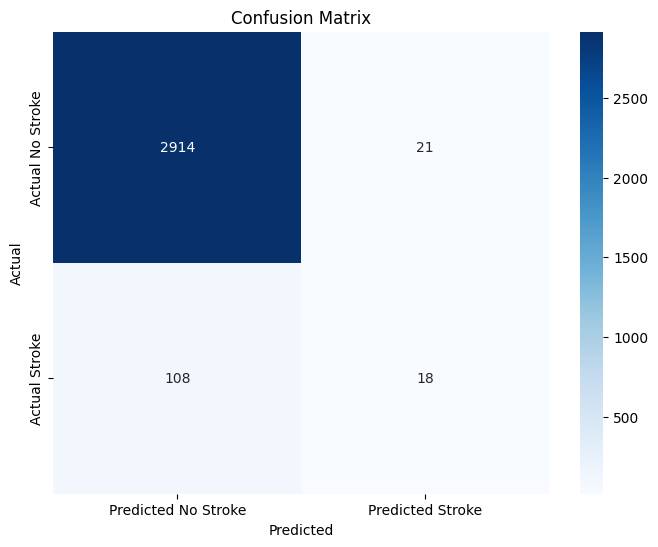

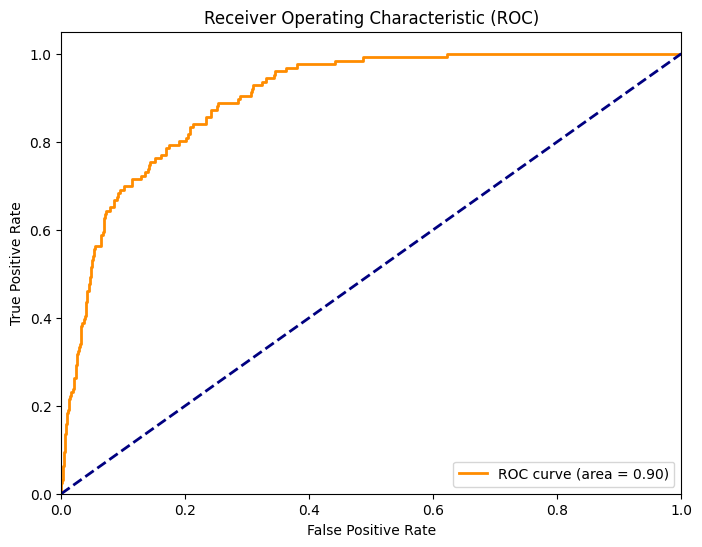

In [40]:
from sklearn.metrics import (precision_score,
                            recall_score,
                            f1_score,
                            roc_auc_score,
                            classification_report,
                            roc_curve)

# Make predictions on the test set
# y_pred
# Calculate evaluation metrics
# precision = precision_score(y_test_pass, y_pred)
# recall = recall_score(y_test_pass, y_pred)
# f1 = f1_score(y_test_pass, y_pred)

# Use the best model (grid_search.best_estimator_) to predict probabilities
roc_auc = roc_auc_score(y_test_pass, best_model.predict_proba(X_test_pass)[:, 1])
class_report = classification_report(y_test_pass, y_pred, digits=4)
class_report_dict = classification_report(y_test_pass, y_pred, output_dict=True)

macro_avg_f1 = class_report_dict['macro avg']['f1-score']
weighted_avg_f1 = class_report_dict['weighted avg']['f1-score']


# Print the evaluation metrics
print(class_report)
print(f"ROC AUC: {roc_auc:.4f}")


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create the confusion matrix
cm = confusion_matrix(y_test_pass, y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted No Stroke', 'Predicted Stroke'],
            yticklabels=['Actual No Stroke', 'Actual Stroke'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_pass, best_model.predict_proba(X_test_pass)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Try dropping each feature

Results without gender
<class 'pandas.core.frame.DataFrame'>
Index: 12242 entries, 3485 to 8924
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   hypertension       12242 non-null  int64  
 1   heart_disease      12242 non-null  int64  
 2   ever_married       12242 non-null  int64  
 3   work_type          12242 non-null  int64  
 4   residence_type     12242 non-null  int64  
 5   smoking_status     12242 non-null  int64  
 6   age                12242 non-null  float64
 7   avg_glucose_level  12242 non-null  float64
 8   bmi                12242 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 956.4 KB
Reclassifying work_type as categorical based on unique values.
Reclassifying smoking_status as categorical based on unique values.
['work_type', 'smoking_status']
['hypertension', 'heart_disease', 'ever_married', 'residence_type', 'age', 'avg_glucose_level', 'bmi']
              precision   

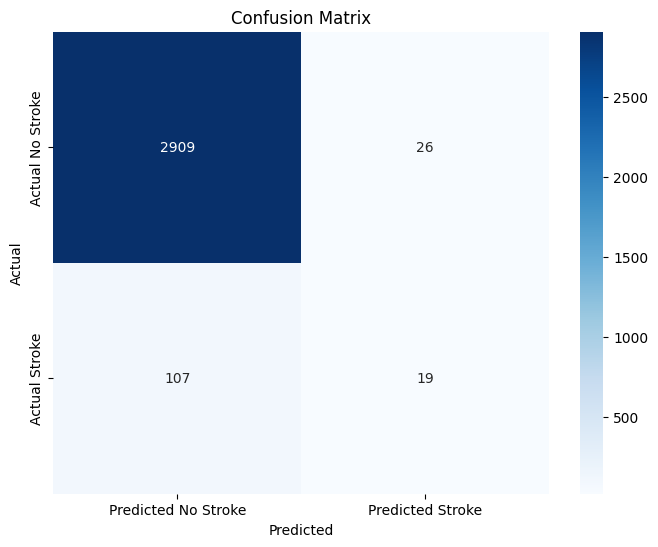

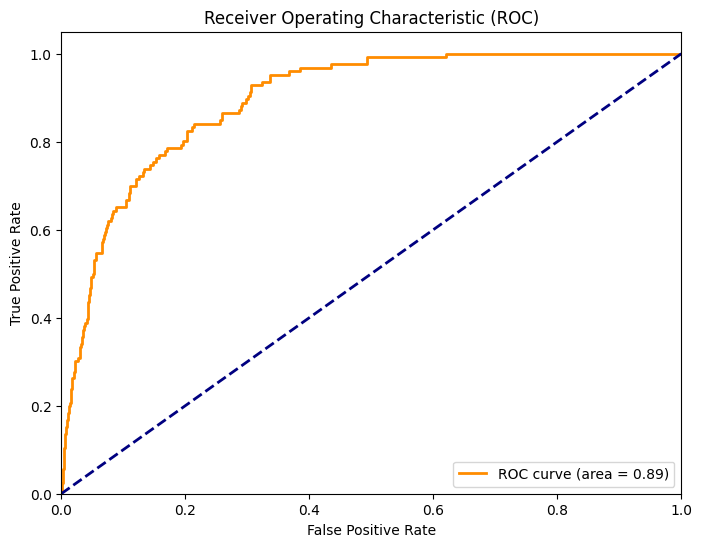

Results without hypertension
<class 'pandas.core.frame.DataFrame'>
Index: 12242 entries, 3485 to 8924
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             12242 non-null  int64  
 1   heart_disease      12242 non-null  int64  
 2   ever_married       12242 non-null  int64  
 3   work_type          12242 non-null  int64  
 4   residence_type     12242 non-null  int64  
 5   smoking_status     12242 non-null  int64  
 6   age                12242 non-null  float64
 7   avg_glucose_level  12242 non-null  float64
 8   bmi                12242 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 956.4 KB
Reclassifying work_type as categorical based on unique values.
Reclassifying smoking_status as categorical based on unique values.
['work_type', 'smoking_status']
['gender', 'heart_disease', 'ever_married', 'residence_type', 'age', 'avg_glucose_level', 'bmi']
              precision   

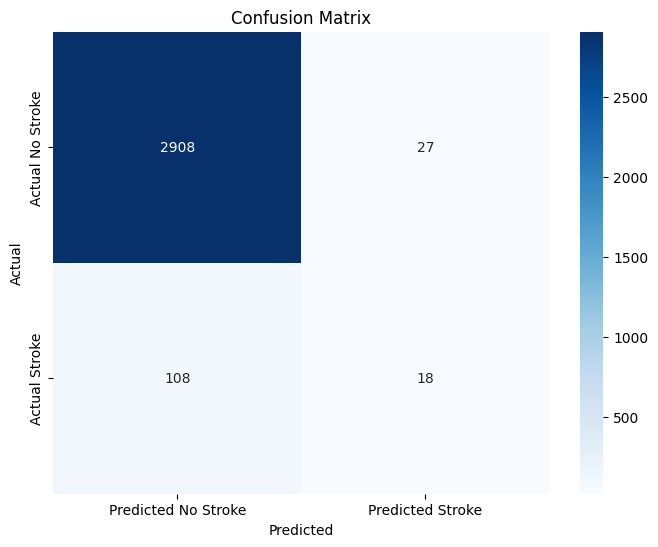

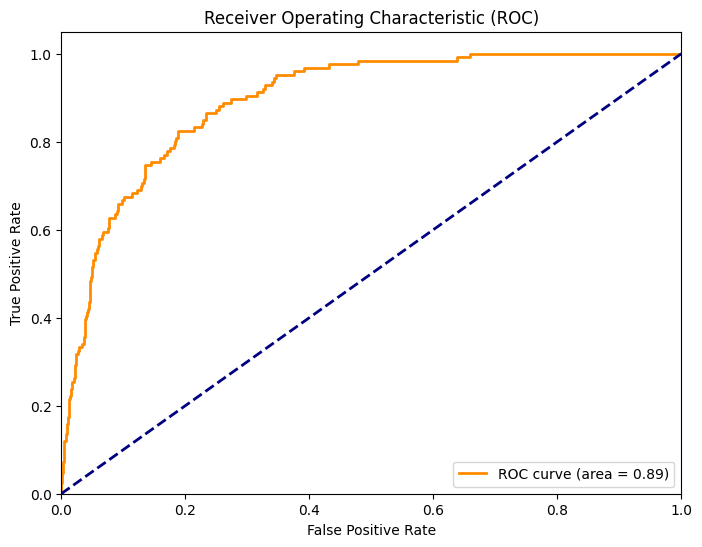

Results without heart_disease
<class 'pandas.core.frame.DataFrame'>
Index: 12242 entries, 3485 to 8924
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             12242 non-null  int64  
 1   hypertension       12242 non-null  int64  
 2   ever_married       12242 non-null  int64  
 3   work_type          12242 non-null  int64  
 4   residence_type     12242 non-null  int64  
 5   smoking_status     12242 non-null  int64  
 6   age                12242 non-null  float64
 7   avg_glucose_level  12242 non-null  float64
 8   bmi                12242 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 956.4 KB
Reclassifying work_type as categorical based on unique values.
Reclassifying smoking_status as categorical based on unique values.
['work_type', 'smoking_status']
['gender', 'hypertension', 'ever_married', 'residence_type', 'age', 'avg_glucose_level', 'bmi']
              precision   

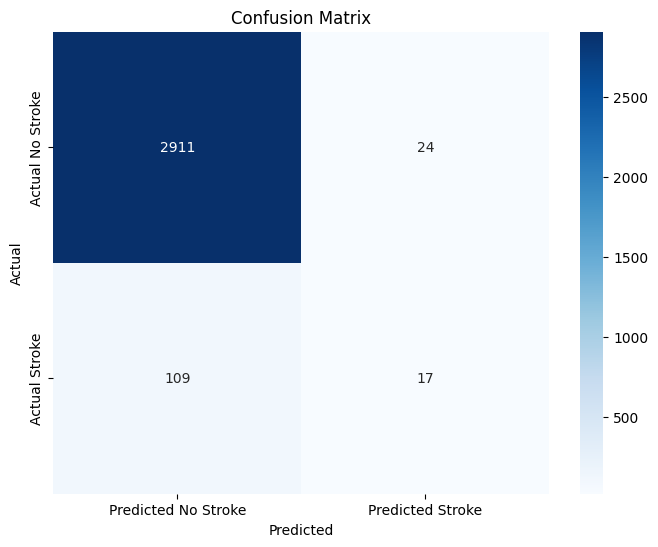

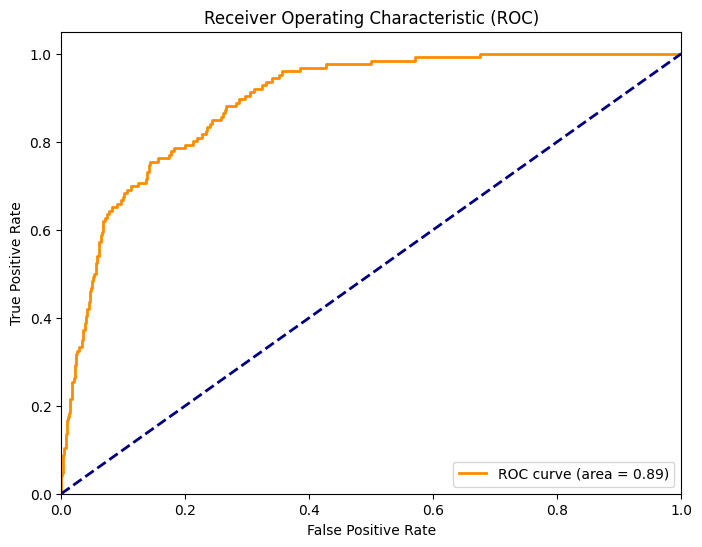

Results without ever_married
<class 'pandas.core.frame.DataFrame'>
Index: 12242 entries, 3485 to 8924
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             12242 non-null  int64  
 1   hypertension       12242 non-null  int64  
 2   heart_disease      12242 non-null  int64  
 3   work_type          12242 non-null  int64  
 4   residence_type     12242 non-null  int64  
 5   smoking_status     12242 non-null  int64  
 6   age                12242 non-null  float64
 7   avg_glucose_level  12242 non-null  float64
 8   bmi                12242 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 956.4 KB
Reclassifying work_type as categorical based on unique values.
Reclassifying smoking_status as categorical based on unique values.
['work_type', 'smoking_status']
['gender', 'hypertension', 'heart_disease', 'residence_type', 'age', 'avg_glucose_level', 'bmi']
              precision   

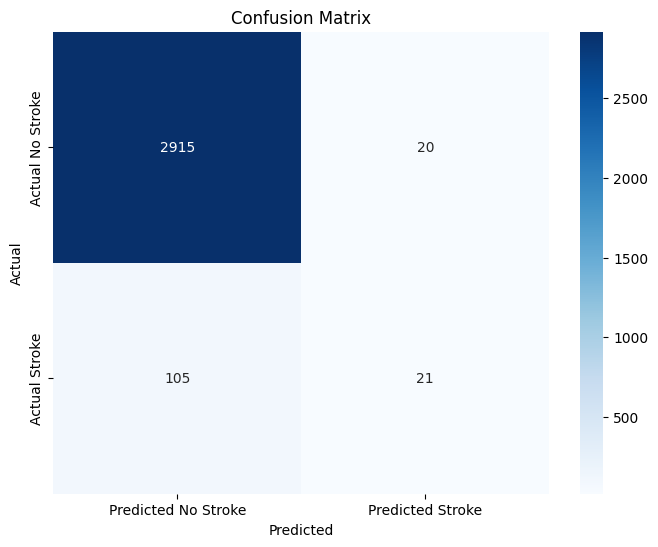

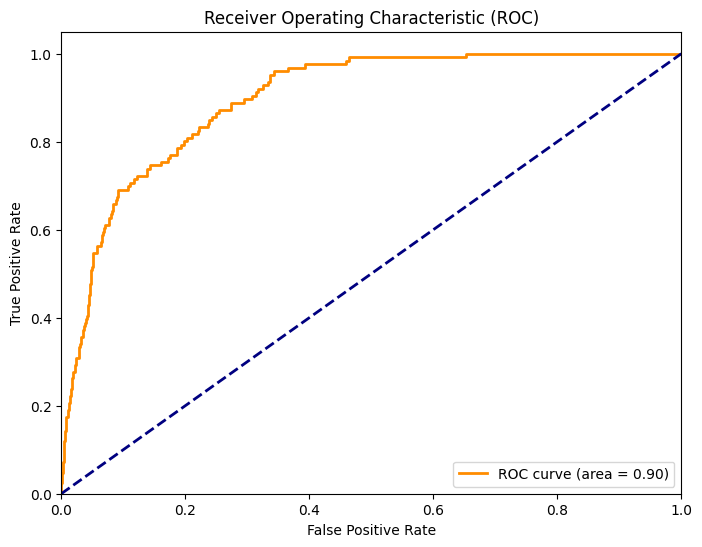

Results without work_type
<class 'pandas.core.frame.DataFrame'>
Index: 12242 entries, 3485 to 8924
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             12242 non-null  int64  
 1   hypertension       12242 non-null  int64  
 2   heart_disease      12242 non-null  int64  
 3   ever_married       12242 non-null  int64  
 4   residence_type     12242 non-null  int64  
 5   smoking_status     12242 non-null  int64  
 6   age                12242 non-null  float64
 7   avg_glucose_level  12242 non-null  float64
 8   bmi                12242 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 956.4 KB
Reclassifying smoking_status as categorical based on unique values.
['smoking_status']
['gender', 'hypertension', 'heart_disease', 'ever_married', 'residence_type', 'age', 'avg_glucose_level', 'bmi']
              precision    recall  f1-score   support

           0     0.9642    0.9911 

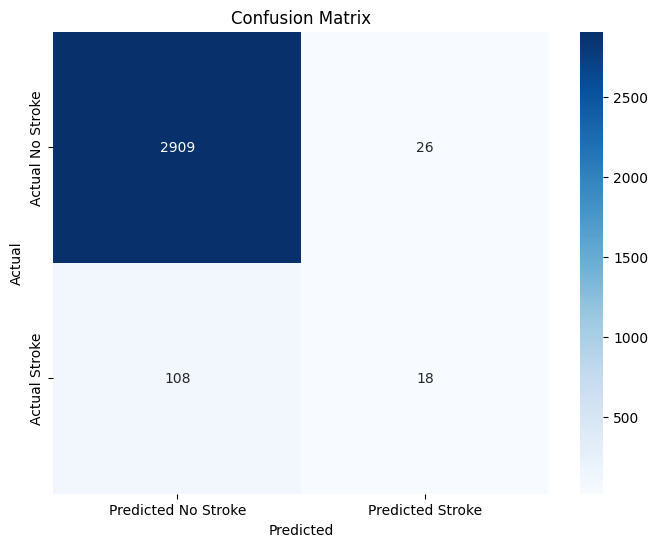

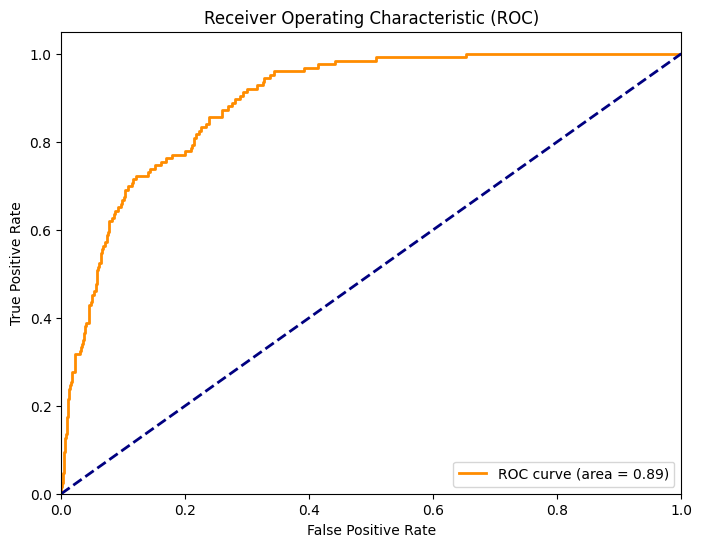

Results without residence_type
<class 'pandas.core.frame.DataFrame'>
Index: 12242 entries, 3485 to 8924
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             12242 non-null  int64  
 1   hypertension       12242 non-null  int64  
 2   heart_disease      12242 non-null  int64  
 3   ever_married       12242 non-null  int64  
 4   work_type          12242 non-null  int64  
 5   smoking_status     12242 non-null  int64  
 6   age                12242 non-null  float64
 7   avg_glucose_level  12242 non-null  float64
 8   bmi                12242 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 956.4 KB
Reclassifying work_type as categorical based on unique values.
Reclassifying smoking_status as categorical based on unique values.
['work_type', 'smoking_status']
['gender', 'hypertension', 'heart_disease', 'ever_married', 'age', 'avg_glucose_level', 'bmi']
              precision   

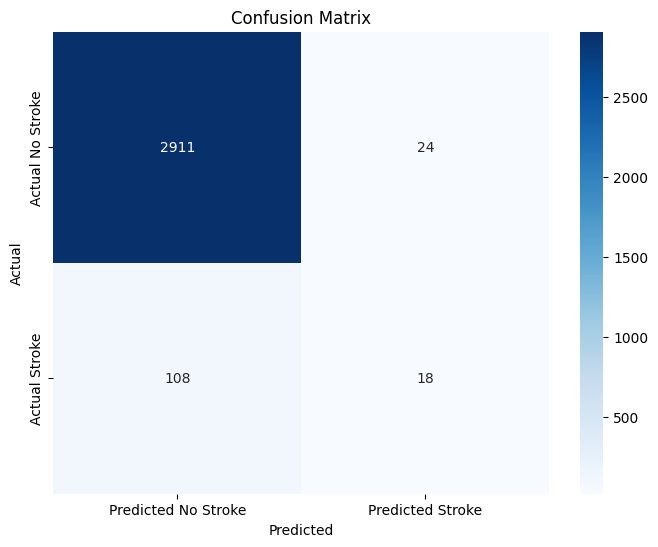

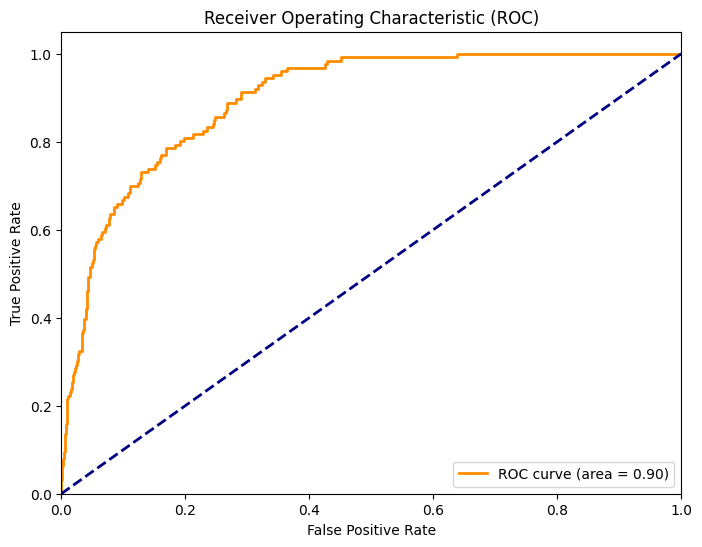

Results without smoking_status
<class 'pandas.core.frame.DataFrame'>
Index: 12242 entries, 3485 to 8924
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             12242 non-null  int64  
 1   hypertension       12242 non-null  int64  
 2   heart_disease      12242 non-null  int64  
 3   ever_married       12242 non-null  int64  
 4   work_type          12242 non-null  int64  
 5   residence_type     12242 non-null  int64  
 6   age                12242 non-null  float64
 7   avg_glucose_level  12242 non-null  float64
 8   bmi                12242 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 956.4 KB
Reclassifying work_type as categorical based on unique values.
['work_type']
['gender', 'hypertension', 'heart_disease', 'ever_married', 'residence_type', 'age', 'avg_glucose_level', 'bmi']
              precision    recall  f1-score   support

           0     0.9649    0.9922    0.

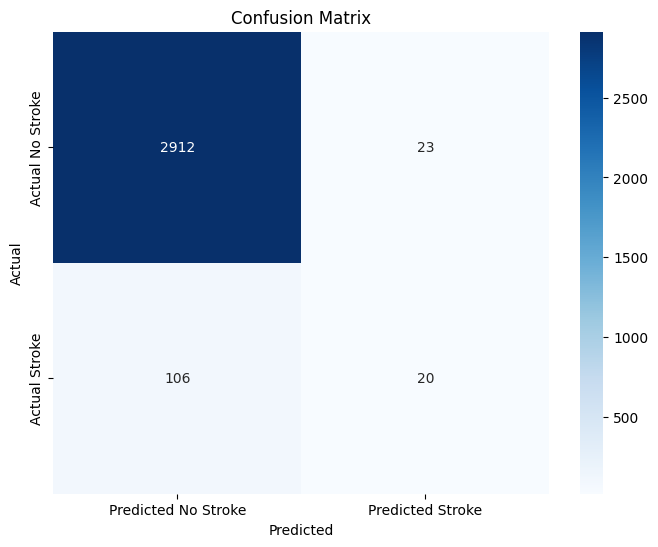

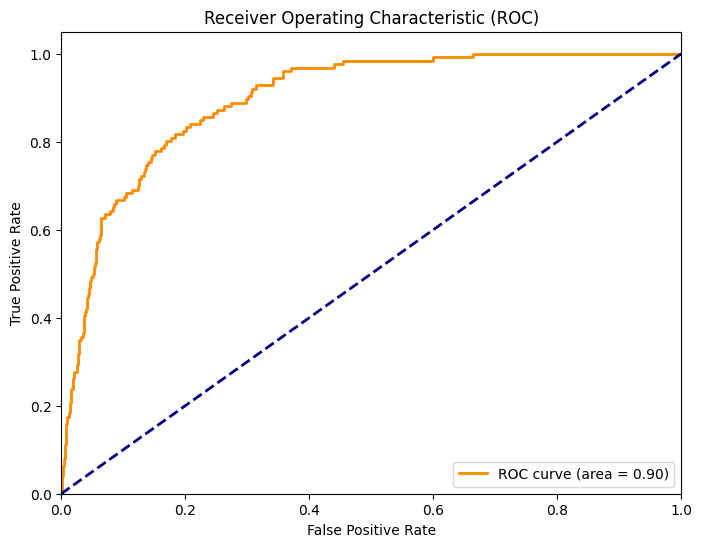

Results without age
<class 'pandas.core.frame.DataFrame'>
Index: 12242 entries, 3485 to 8924
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             12242 non-null  int64  
 1   hypertension       12242 non-null  int64  
 2   heart_disease      12242 non-null  int64  
 3   ever_married       12242 non-null  int64  
 4   work_type          12242 non-null  int64  
 5   residence_type     12242 non-null  int64  
 6   smoking_status     12242 non-null  int64  
 7   avg_glucose_level  12242 non-null  float64
 8   bmi                12242 non-null  float64
dtypes: float64(2), int64(7)
memory usage: 956.4 KB
Reclassifying work_type as categorical based on unique values.
Reclassifying smoking_status as categorical based on unique values.
['work_type', 'smoking_status']
['gender', 'hypertension', 'heart_disease', 'ever_married', 'residence_type', 'avg_glucose_level', 'bmi']
              precision   

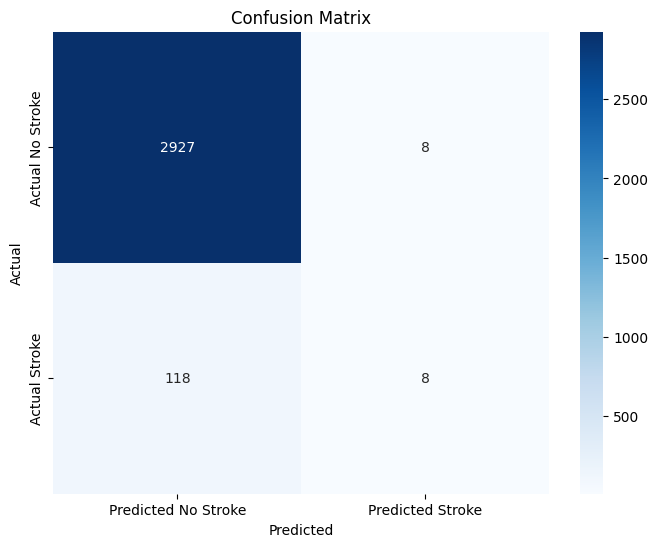

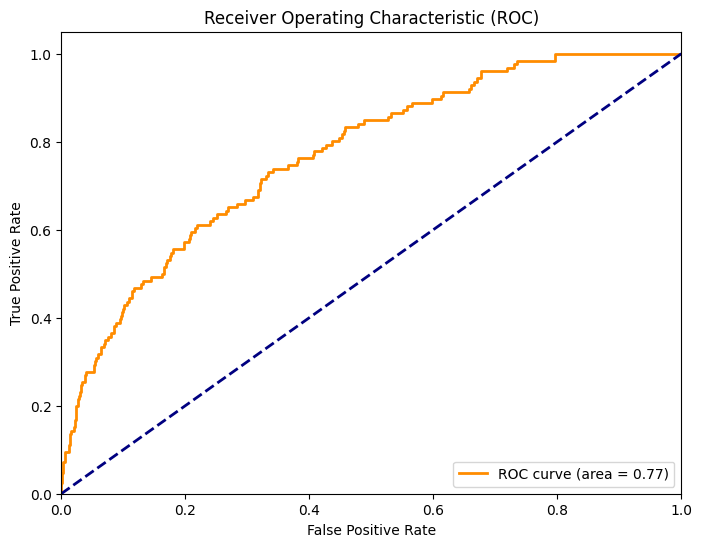

Results without avg_glucose_level
<class 'pandas.core.frame.DataFrame'>
Index: 12242 entries, 3485 to 8924
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gender          12242 non-null  int64  
 1   hypertension    12242 non-null  int64  
 2   heart_disease   12242 non-null  int64  
 3   ever_married    12242 non-null  int64  
 4   work_type       12242 non-null  int64  
 5   residence_type  12242 non-null  int64  
 6   smoking_status  12242 non-null  int64  
 7   age             12242 non-null  float64
 8   bmi             12242 non-null  float64
dtypes: float64(2), int64(7)
memory usage: 956.4 KB
Reclassifying work_type as categorical based on unique values.
Reclassifying smoking_status as categorical based on unique values.
['work_type', 'smoking_status']
['gender', 'hypertension', 'heart_disease', 'ever_married', 'residence_type', 'age', 'bmi']
              precision    recall  f1-score   support

    

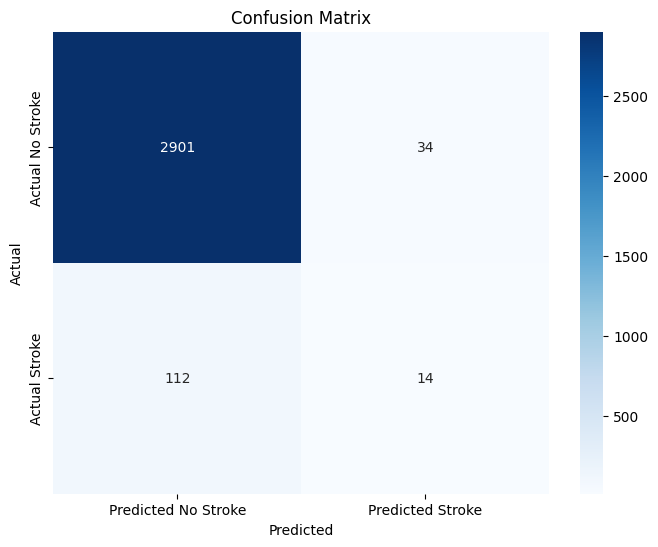

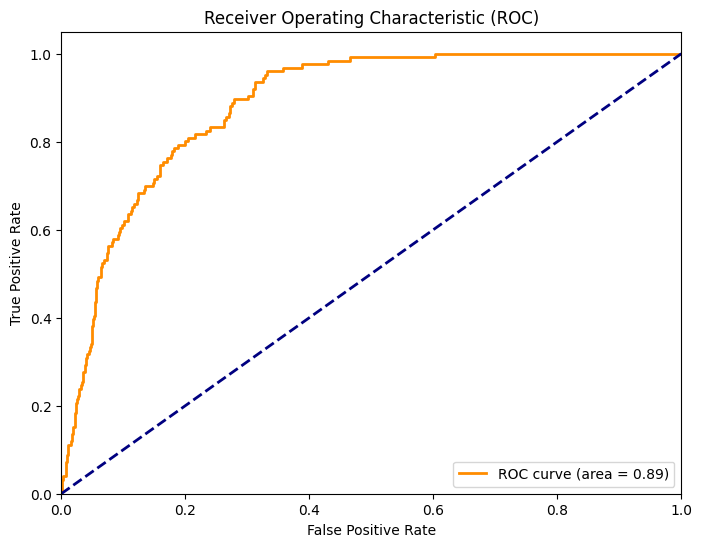

Results without bmi
<class 'pandas.core.frame.DataFrame'>
Index: 12242 entries, 3485 to 8924
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             12242 non-null  int64  
 1   hypertension       12242 non-null  int64  
 2   heart_disease      12242 non-null  int64  
 3   ever_married       12242 non-null  int64  
 4   work_type          12242 non-null  int64  
 5   residence_type     12242 non-null  int64  
 6   smoking_status     12242 non-null  int64  
 7   age                12242 non-null  float64
 8   avg_glucose_level  12242 non-null  float64
dtypes: float64(2), int64(7)
memory usage: 956.4 KB
Reclassifying work_type as categorical based on unique values.
Reclassifying smoking_status as categorical based on unique values.
['work_type', 'smoking_status']
['gender', 'hypertension', 'heart_disease', 'ever_married', 'residence_type', 'age', 'avg_glucose_level']
              precision   

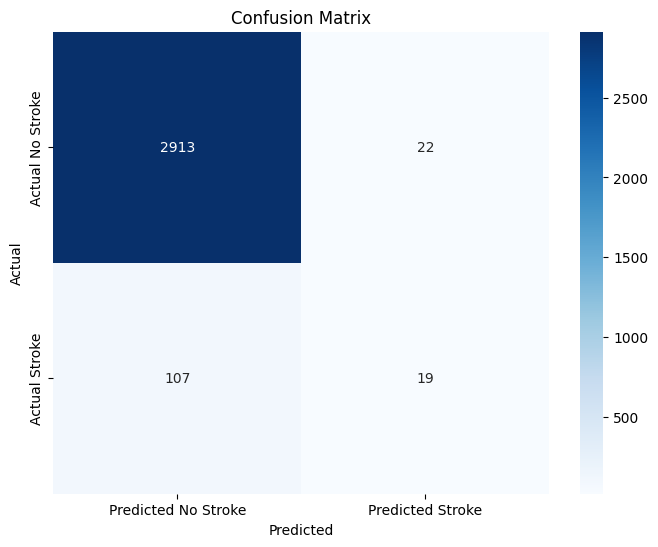

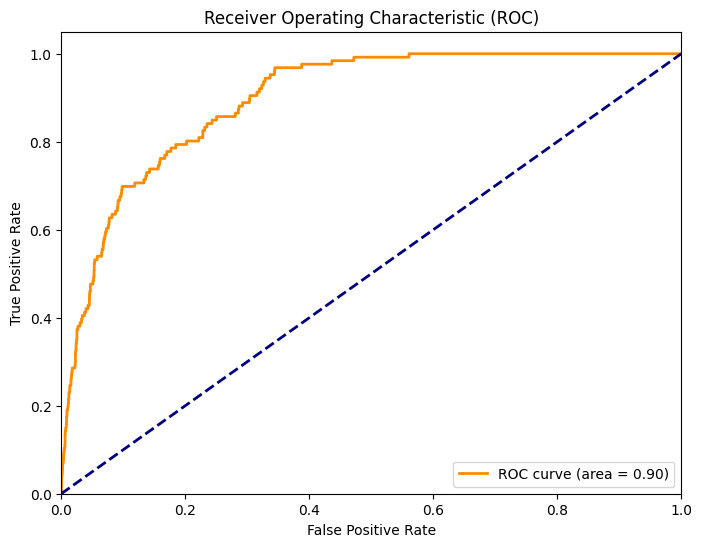

In [41]:
results = pd.DataFrame(columns = ['features', 'macro_avg_f1', 'weighted_avg_f1', 'roc_auc'])
results = results.set_index('features')
results.loc['all'] = {'macro_avg_f1': macro_avg_f1, 'weighted_avg_f1': weighted_avg_f1, 'roc_auc': roc_auc}

for column in X.columns:
    print("Results without", column)
    incompleted_X = X.drop(columns=[column])
    X_train, X_test, y_train, y_test = train_test_split(incompleted_X, y, test_size=0.2, stratify=y, random_state=42)

    X_pass, y_pass = get_pass_data(X_train, y_train)
    X_test_pass, y_test_pass = get_pass_data(X_test, y_test, False)

    tempgskfold = get_gskf_pipeline(X_pass, params)
    tempgskfold.fit(X_pass, y_pass)
    
    temp_best_model = tempgskfold.best_estimator_
    y_pred = temp_best_model.predict(X_test_pass)

    roc_auc = roc_auc_score(y_test_pass, temp_best_model.predict_proba(X_test_pass)[:, 1])
    class_report = classification_report(y_test_pass, y_pred, digits=4)
    class_report_dict = classification_report(y_test_pass, y_pred, output_dict=True)

    macro_avg_f1 = class_report_dict['macro avg']['f1-score']
    weighted_avg_f1 = class_report_dict['weighted avg']['f1-score']

    print(class_report)
    print(f"ROC AUC: {roc_auc:.4f}")

    # Create the confusion matrix
    cm = confusion_matrix(y_test_pass, y_pred)
    
    # Plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Predicted No Stroke', 'Predicted Stroke'],
                yticklabels=['Actual No Stroke', 'Actual Stroke'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test_pass, temp_best_model.predict_proba(X_test_pass)[:, 1])
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    results.loc['without ' + column] = {'macro_avg_f1': macro_avg_f1, 'weighted_avg_f1': weighted_avg_f1, 'roc_auc': roc_auc}

Results without ever_married
<class 'pandas.core.frame.DataFrame'>
Index: 12242 entries, 3485 to 8924
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             12242 non-null  int64  
 1   hypertension       12242 non-null  int64  
 2   heart_disease      12242 non-null  int64  
 3   work_type          12242 non-null  int64  
 4   residence_type     12242 non-null  int64  
 5   smoking_status     12242 non-null  int64  
 6   age                12242 non-null  float64
 7   avg_glucose_level  12242 non-null  float64
 8   bmi                12242 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 956.4 KB
Reclassifying work_type as categorical based on unique values.
Reclassifying smoking_status as categorical based on unique values.
['work_type', 'smoking_status']
['gender', 'hypertension', 'heart_disease', 'residence_type', 'age', 'avg_glucose_level', 'bmi']
              precision   

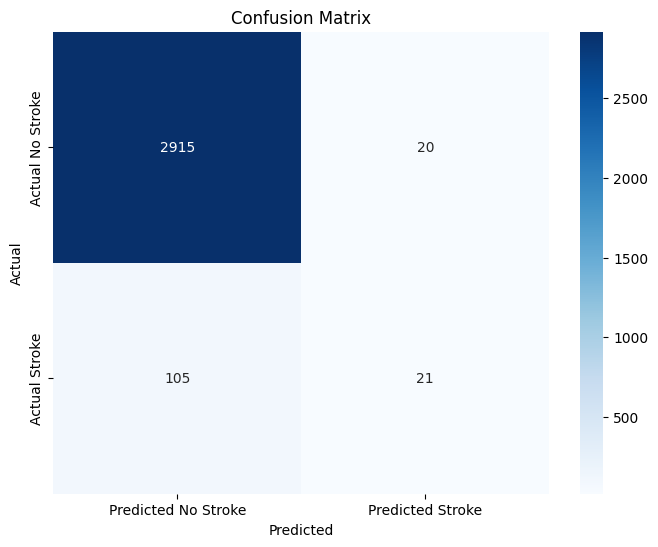

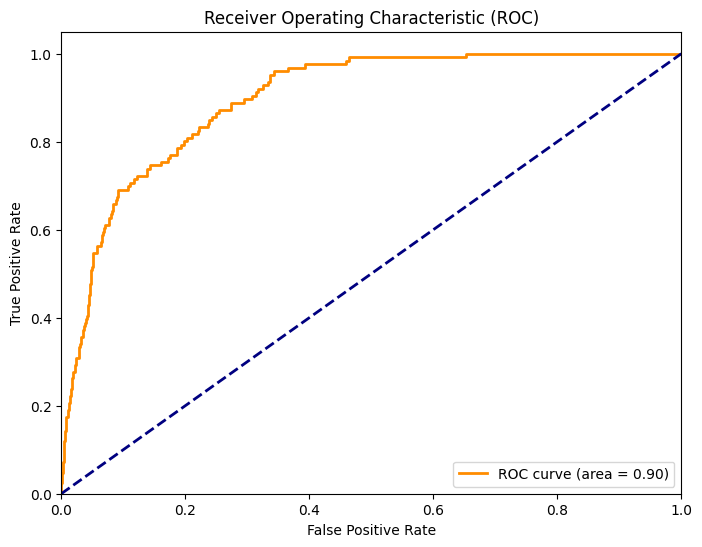

In [42]:
print("Results without ever_married")
final_X = X.drop(columns=['ever_married'])
X_train, X_test, y_train, y_test = train_test_split(final_X, y, test_size=0.2, stratify=y, random_state=42)

X_pass, y_pass = get_pass_data(X_train, y_train)
X_test_pass, y_test_pass = get_pass_data(X_test, y_test, False)

finalgskfold = get_gskf_pipeline(X_pass, params)
finalgskfold.fit(X_pass, y_pass)

final_best_model = finalgskfold.best_estimator_
y_pred = final_best_model.predict(X_test_pass)

roc_auc = roc_auc_score(y_test_pass, final_best_model.predict_proba(X_test_pass)[:, 1])
class_report = classification_report(y_test_pass, y_pred, digits=4)
class_report_dict = classification_report(y_test_pass, y_pred, digits=4, output_dict=True)

macro_avg_f1 = class_report_dict['macro avg']['f1-score']
weighted_avg_f1 = class_report_dict['weighted avg']['f1-score']

print(class_report)
print(f"ROC AUC: {roc_auc:.4f}")

# Create the confusion matrix
cm = confusion_matrix(y_test_pass, y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted No Stroke', 'Predicted Stroke'],
            yticklabels=['Actual No Stroke', 'Actual Stroke'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_pass, final_best_model.predict_proba(X_test_pass)[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

#results.loc['wo ever_married residence_type'] = {'macro_avg_f1': macro_avg_f1, 'weighted_avg_f1': weighted_avg_f1, 'roc_auc': roc_auc}

In [43]:
X_all_pass, y_all_pass = get_pass_data(final_X, y)

y_all_pred = final_best_model.predict_proba(X_all_pass)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15303 entries, 0 to 15302
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             15303 non-null  int64  
 1   hypertension       15303 non-null  int64  
 2   heart_disease      15303 non-null  int64  
 3   work_type          15303 non-null  int64  
 4   residence_type     15303 non-null  int64  
 5   smoking_status     15303 non-null  int64  
 6   age                15303 non-null  float64
 7   avg_glucose_level  15303 non-null  float64
 8   bmi                15303 non-null  float64
dtypes: float64(3), int64(6)
memory usage: 1.1 MB


In [44]:
y_all_pred

array([[0.98136438, 0.01863563],
       [0.97285983, 0.02714017],
       [0.97233808, 0.02766192],
       ...,
       [0.87309877, 0.12690123],
       [0.97706951, 0.0229305 ],
       [0.98161327, 0.01838674]])

In [45]:
results

,macro_avg_f1,weighted_avg_f1,roc_auc
features,,,
all,0.598263,0.947054,0.900284
without gender,0.599937,0.946555,0.894846
without hypertension,0.593921,0.945751,0.894668
without heart_disease,0.590629,0.945803,0.893172
without ever_married,0.615253,0.949063,0.896812
without work_type,0.594626,0.945967,0.893637
without residence_type,0.596058,0.946400,0.897526
without smoking_status,0.607508,0.947802,0.897612
without age,0.545803,0.943272,0.770277


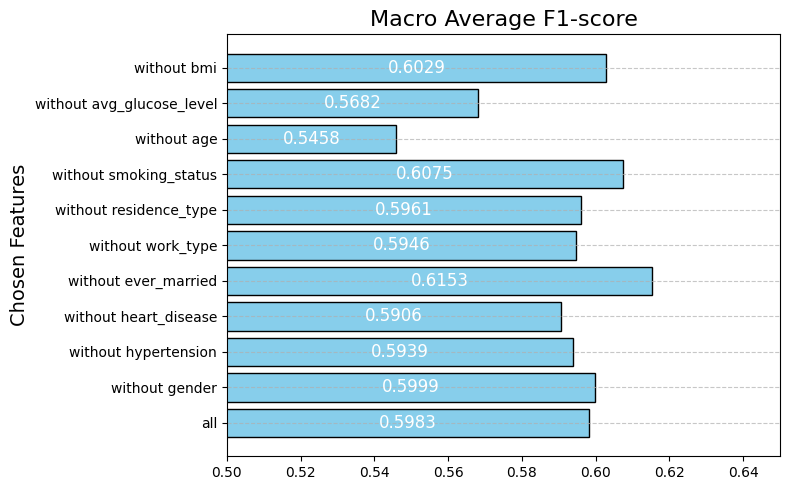

In [46]:
plt.figure(figsize=(8, 5))
#results['macro_avg_f1'].plot(kind='barh', color='skyblue', edgecolor='black')
plt.xlim(0.5, 0.65)
data = results['macro_avg_f1']

bars = plt.barh(data.index, data, color='skyblue', edgecolor='black')
plt.bar_label(bars, label_type='center', color='white', fontsize=12, fmt="%.4f")


# Adding labels and title
plt.title('Macro Average F1-score', fontsize=16)
plt.ylabel('Chosen Features', fontsize=14)

# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

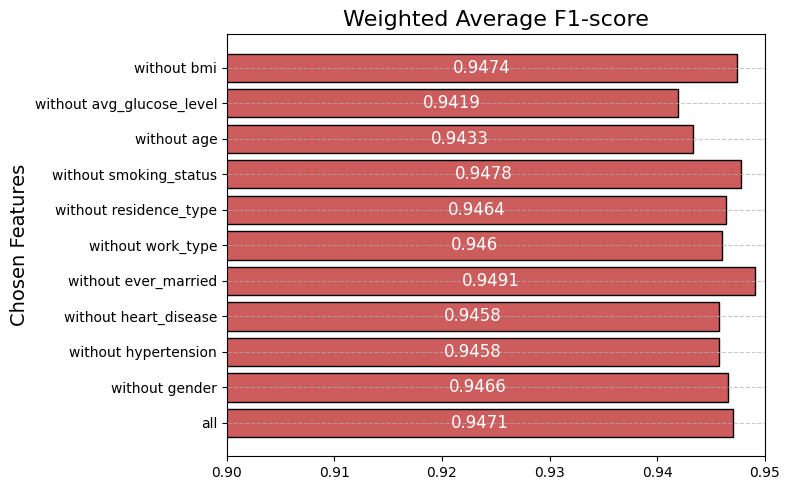

In [47]:
plt.figure(figsize=(8, 5))
#results['weighted_avg_f1'].plot(kind='barh', color='indianred', edgecolor='black')
plt.xlim(0.9, 0.95)

data = results['weighted_avg_f1'].round(4)

bars = plt.barh(data.index, data, color='indianred', edgecolor='black')
plt.bar_label(bars, label_type='center', color='white', fontsize=12)


# Adding labels and title
plt.title('Weighted Average F1-score', fontsize=16)
plt.ylabel('Chosen Features', fontsize=14)


# Show the plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<Figure size 1500x600 with 0 Axes>

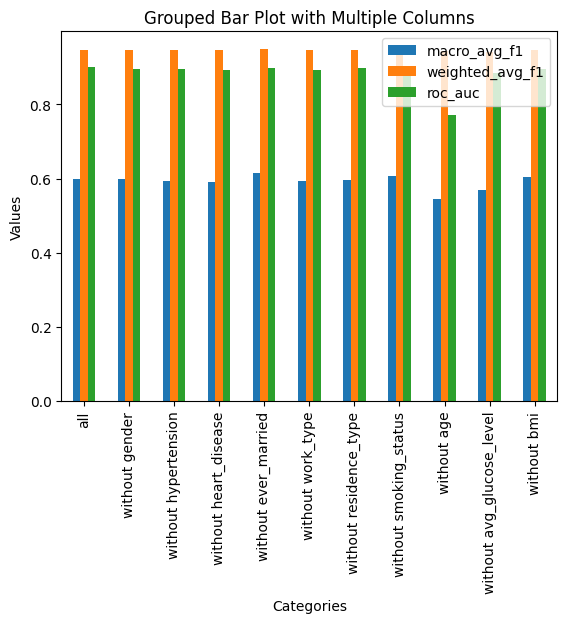

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# Set 'Category' as the index to easily plot
results.plot(kind='bar')

# Add title and labels
plt.title('Grouped Bar Plot with Multiple Columns')
plt.xlabel('Categories')
plt.ylabel('Values')

# Show plot
plt.show()

## Interpret

In [49]:
%pip install eli5
import eli5

Note: you may need to restart the kernel to use updated packages.


In [50]:
y_pred = final_best_model.predict(X_test_pass.iloc[0:1])

In [51]:
preprocessor = final_best_model.named_steps['preprocessor']

In [52]:
xgb_feature_importances = final_best_model['classifier'].estimators_[0].feature_importances_
catboost_feature_importances = final_best_model['classifier'].estimators_[1].feature_importances_
rf_feature_importances = final_best_model['classifier'].estimators_[2].feature_importances_  # Get RandomForest importances

# Calculate average feature importances from all three models
feature_importances = (xgb_feature_importances + catboost_feature_importances + rf_feature_importances) / 3

# Get feature names after preprocessing
feature_names = final_best_model['preprocessor'].get_feature_names_out()

# Create a DataFrame to store feature importances and names
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(importance_df)

                   Feature  Importance
4                 num__age   11.454769
6                 num__bmi    7.358905
5   num__avg_glucose_level    6.326399
0              num__gender    1.248010
3      num__residence_type    1.220663
15   cat__smoking_status_3    1.219502
7         cat__work_type_0    0.891989
14   cat__smoking_status_2    0.666985
13   cat__smoking_status_1    0.626815
8         cat__work_type_1    0.599108
12   cat__smoking_status_0    0.544516
1        num__hypertension    0.537921
9         cat__work_type_2    0.515570
10        cat__work_type_3    0.445470
2       num__heart_disease    0.334154
11        cat__work_type_4    0.009223


In [53]:
xgb_model = final_best_model['classifier'].estimators_[0]
catboost_model = final_best_model['classifier'].estimators_[1]
rf_model = final_best_model['classifier'].estimators_[2]

In [54]:
eli5.show_weights(xgb_model)

Weight,Feature
0.4409,f4
0.0867,f5
0.0607,f1
0.0571,f8
0.0509,f14
0.0460,f6
0.0396,f15
0.0378,f7
0.0359,f13
0.0321,f2


In [55]:
# Explain CatBoostClassifier (use 'get_feature_importance' instead of eli5)
print("Feature Importances for CatBoostClassifier:")
eli5.show_weights(catboost_model)

Feature Importances for CatBoostClassifier:


Weight,Feature
0.3347,4
0.2186,6
0.1870,5
0.0370,0
0.0361,3
0.0361,15
0.0263,7
0.0194,14
0.0183,13
0.0173,8


In [56]:
# Explain RandomForestClassifier
print("Feature Importances for RandomForestClassifier:")
eli5.show_weights(rf_model)


Feature Importances for RandomForestClassifier:


Weight,Feature
0.4559 ± 0.1324,x4
0.1895 ± 0.0564,x5
0.1706 ± 0.0568,x6
0.0295 ± 0.0365,x1
0.0269 ± 0.0636,x10
0.0207 ± 0.0115,x3
0.0186 ± 0.0119,x0
0.0135 ± 0.0141,x2
0.0123 ± 0.0119,x13
0.0122 ± 0.0142,x8


In [57]:
import pandas as pd

data = {
    "gender": [0],
    "hypertension": [0],
    "heart_disease": [1],
    "work_type": [2],
    "smoking_status": [0],
    "age": [25.0],
    "avg_glucose_level": [10000],
    "bmi": [32.4]
}
hihi = pd.DataFrame(data)

In [58]:
hihi

,gender,hypertension,heart_disease,work_type,smoking_status,age,avg_glucose_level,bmi
0,0,0,1,2,0,25.0,10000,32.4


In [59]:
idx = 2916
instance = X_test_pass.iloc[idx:idx+1]

In [60]:
instance

,gender,hypertension,heart_disease,work_type,residence_type,smoking_status,age,avg_glucose_level,bmi
12241,0,0,1,2,1,1,80.0,235.54,32.4


In [61]:
model = final_best_model['classifier']

In [62]:
preprocessor = final_best_model['preprocessor']

In [63]:
x_transform = preprocessor.transform(instance)
x_transform

array([[  0.  ,   0.  ,   1.  ,   1.  ,  80.  , 235.54,  32.4 ,   0.  ,
          0.  ,   1.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ]])

In [64]:
model.predict(x_transform)

array([1])

In [65]:
import shap

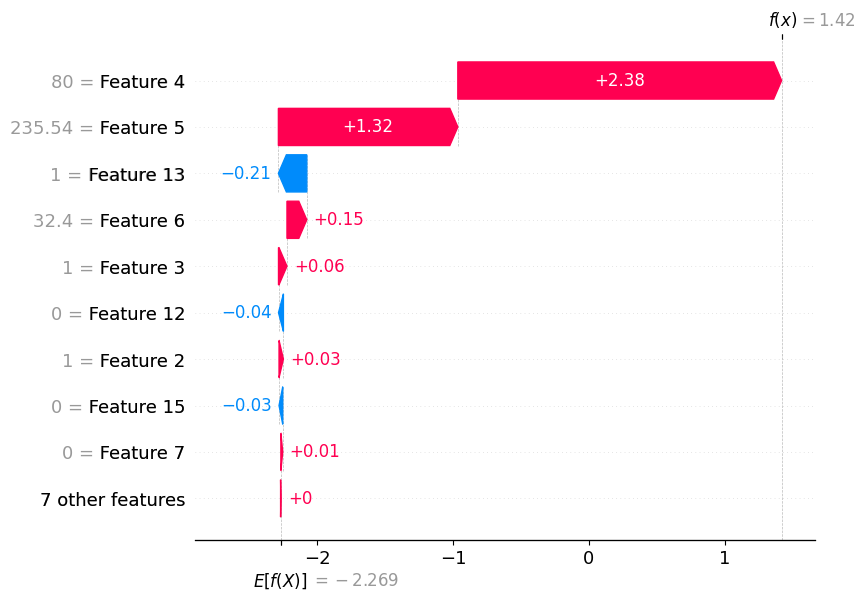

In [66]:
# SHAP cho XGBRFClassifier
explainer_xgb = shap.Explainer(xgb_model)
shap_values_xgb = explainer_xgb(x_transform)
shap.plots.waterfall(shap_values_xgb[0])

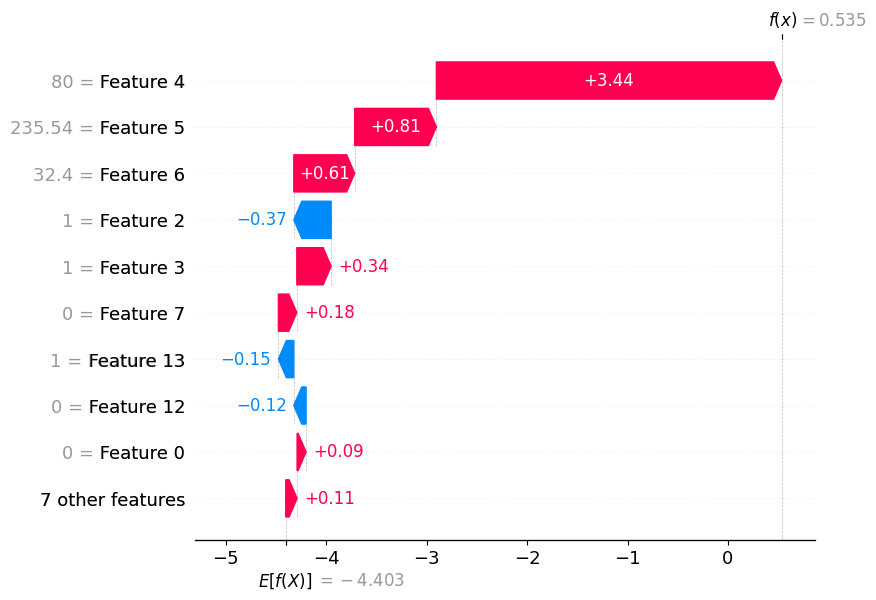

In [67]:
# SHAP cho CatBoostClassifier
explainer_cat = shap.Explainer(catboost_model)
shap_values_cat = explainer_cat(x_transform)
shap.plots.waterfall(shap_values_cat[0])

In [68]:
shap_values_cat.shape

(1, 16)

In [69]:
shap_values_cat

.values =
array([[ 8.93335236e-02,  3.67637115e-02, -3.71914734e-01,
         3.42020067e-01,  3.43791443e+00,  8.13887069e-01,
         6.05785749e-01,  1.83635832e-01, -6.72479459e-02,
         6.10351113e-02,  2.81571730e-02, -1.11568619e-04,
        -1.22651358e-01, -1.53095117e-01,  3.32580239e-02,
         2.11689230e-02]])

.base_values =
array([-4.40308608])

.data =
array([[  0.  ,   0.  ,   1.  ,   1.  ,  80.  , 235.54,  32.4 ,   0.  ,
          0.  ,   1.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ]])

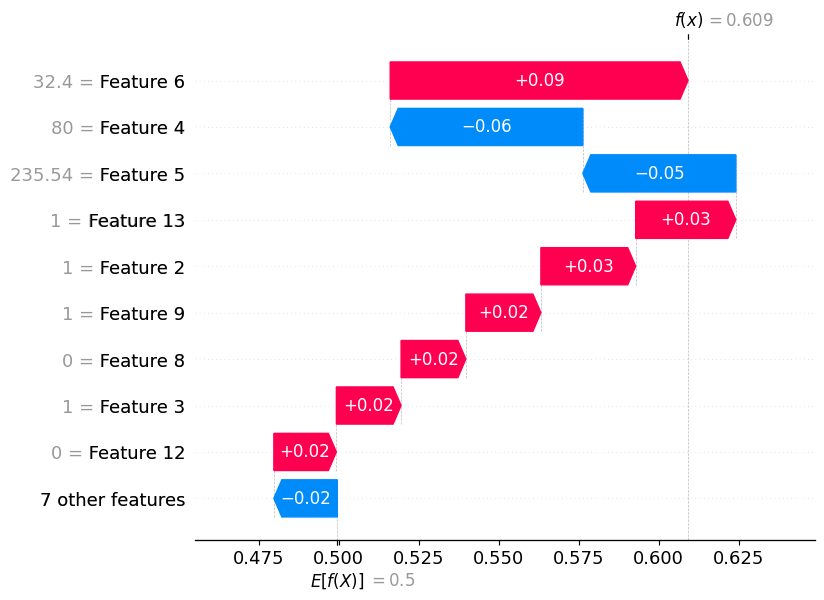

In [70]:
explainer_rf = shap.Explainer(rf_model)
shap_values_rf = explainer_rf(x_transform)

# Chọn SHAP values cho class 1
shap_values_class1 = shap.Explanation(
    values=shap_values_rf.values[:, :, 0],  # Chọn SHAP values cho lớp 1
    base_values=shap_values_rf.base_values[:, 1],  # Chọn base_values cho lớp 1
    data=x_transform  # Input features
)

# Vẽ waterfall plot cho mẫu đầu tiên
shap.plots.waterfall(shap_values_class1[0])

In [71]:
shap_values_rf.shape

(1, 16, 2)

In [72]:
now = preprocessor.transform(instance).reshape(-1)

In [73]:
hihi

,gender,hypertension,heart_disease,work_type,smoking_status,age,avg_glucose_level,bmi
0,0,0,1,2,0,25.0,10000,32.4


In [74]:
now

array([  0.  ,   0.  ,   1.  ,   1.  ,  80.  , 235.54,  32.4 ,   0.  ,
         0.  ,   1.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ])

In [75]:
from lime.lime_tabular import LimeTabularExplainer

# Giả sử bạn có feature_names và class_names
X_test_transform = preprocessor.transform(X_test_pass)
explainer = LimeTabularExplainer(X_test_transform, mode="classification")

# Giải thích kết quả dự đoán
exp = explainer.explain_instance(now, model.predict_proba)
exp.show_in_notebook()

In [76]:
# Get the list of feature importance (contributions) for all classes
feature_importance = exp.as_list()  # This gives a list of tuples (feature_name, importance)

# Print feature importance for all classes
print("Feature Importance:")
for feature, importance in feature_importance:
    print(f"{feature}: {importance}")

# Get the predicted class probabilities
pred_probs = exp.predict_proba  # This contains the probabilities for each class
print("\nPredicted Class Probabilities:")
print(pred_probs)

# Get the predicted class label by finding the index with the highest probability
pred_class = pred_probs.argmax()  # This will return the index of the class with the highest probability
print(f"Predicted Class: {pred_class}")

# Check available labels in local_exp
print("\nAvailable labels in local_exp:", exp.local_exp.keys())

# If you want to get the top N features for the most probable class
if pred_class in exp.local_exp:
    top_features = exp.as_list(label=pred_class)[:5]  # Top 5 features for the predicted class
    print(f"\nTop Features for Class {pred_class}:")
    for feature, importance in top_features:
        print(f"{feature}: {importance}")
else:
    print(f"Class {pred_class} not found in explanation.")


Feature Importance:
4 > 57.00: 0.18896956828368333
1 <= 0.00: -0.026858751443974604
6 > 32.10: 0.025876522446511712
5 > 96.84: 0.01839554483300301
2 > 0.00: 0.016845851500985165
14 <= 0.00: -0.015698829101270406
8 <= 0.00: 0.01021378836002473
11 <= 0.00: -0.00717875958297194
12 <= 0.00: 0.007104317193563877
7 <= 0.00: -0.0065254976406961054

Predicted Class Probabilities:
[0.39132963 0.60867037]
Predicted Class: 1

Available labels in local_exp: dict_keys([1])

Top Features for Class 1:
4 > 57.00: 0.18896956828368333
1 <= 0.00: -0.026858751443974604
6 > 32.10: 0.025876522446511712
5 > 96.84: 0.01839554483300301
2 > 0.00: 0.016845851500985165


In [77]:
# Check predicted class from the probabilities
pred_class = pred_probs.argmax()  # This will give you the class with the highest probability
print(f"Predicted Class: {pred_class}")

# Check available labels in local_exp
print("\nAvailable labels in local_exp:", exp.local_exp.keys())

# If the predicted class is not in the explanation, we can still analyze the explanation for class 1
if pred_class in exp.local_exp:
    top_features = exp.as_list(label=pred_class)[:5]  # Top 5 features for the predicted class
    print(f"\nTop Features for Predicted Class {pred_class}:")
    for feature, importance in top_features:
        print(f"{feature}: {importance}")
else:
    print(f"Class {pred_class} not found in explanation. Showing explanation for available class (class 1):")
    top_features = exp.as_list(label=1)[:5]  # Top 5 features for class 1 (even if it's not predicted)
    for feature, importance in top_features:
        print(f"{feature}: {importance}")


Predicted Class: 1

Available labels in local_exp: dict_keys([1])

Top Features for Predicted Class 1:
4 > 57.00: 0.18896956828368333
1 <= 0.00: -0.026858751443974604
6 > 32.10: 0.025876522446511712
5 > 96.84: 0.01839554483300301
2 > 0.00: 0.016845851500985165


In [78]:
y_test_pass.iloc[118:130]

12517    0
9588     0
696      0
4710     0
14763    0
6634     0
14869    0
1332     0
14782    0
3006     1
9903     0
11954    0
Name: stroke, dtype: int64

In [79]:
import numpy as np

# Giả sử y_test_pass và y_pred đều là NumPy arrays hoặc có thể chuyển thành NumPy arrays
y_test_array = np.array(y_test_pass)
y_pred_array = np.array(y_pred)

# Tìm chỉ số thỏa điều kiện
common_indices = np.where((y_test_array == 1) & (y_pred_array == 1))[0]

# In kết quả
print("Các chỉ số mà y_test_pass và y_pred đều bằng 1:")
print(common_indices)


Các chỉ số mà y_test_pass và y_pred đều bằng 1:
[]


In [80]:
import pickle
with open("model.pkl", "wb") as f:
    pickle.dump(final_best_model, f)